# Show locations of TAO arrays ingested in ECCOv4r4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray

import cartopy.crs as ccrs
import re

In [2]:
plt.style.use('thesis')

Read from the csv file

In [3]:
filename = 'MRB_CSV/tao_grep.txt'

In [4]:
read = {'Latitude': lambda line : float(line.split(',decimal')[0].split(' ')[-1]),
        'Longitude': lambda line : float(line.split(',decimal')[0].split(' ')[-1]),
        'Year': lambda line : int(line.split(',,,')[0].split(' ')[-1]),
        'Month': lambda line : int(line.split(',,,')[0].split(' ')[-1]),
        'Day': lambda line : int(line.split(',,,')[0].split(' ')[-1])
       }

In [5]:
tao = {key:[] for key in read.keys()}

In [6]:
with open(filename,'r') as f:
    for line in f:
        for key, readme in read.items():
            if key in line:
                tao[key].append(readme(line))

Create date and sort

In [7]:
tao['date'] = [np.datetime64(f'{Y}-{M:02d}-{D:02d}') for Y,M,D in zip(tao['Year'],tao['Month'],tao['Day'])]

In [8]:
tao_sorted = {}
for key in tao.keys():
    tao_sorted[key] = [x for _,x in sorted(zip(tao['date'],tao[key]))]

Plot

In [9]:
ticks = np.linspace(0,len(tao['date'])-1,5)
ticklabels = [tao_sorted['date'][int(tt)] for tt in ticks]

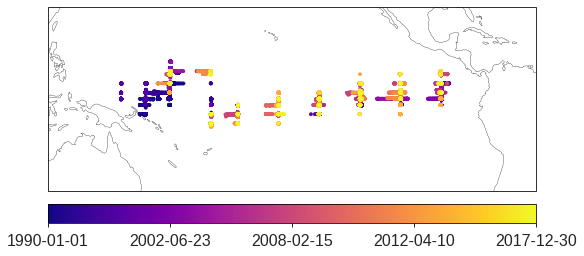

In [10]:
fig, ax = plt.subplots(constrained_layout=True,
                       subplot_kw={'projection':ccrs.Robinson(central_longitude=-180)})

ax.set_extent([-240, -60, -30, 30], crs=ccrs.PlateCarree())

mappable = ax.scatter(tao_sorted['Longitude'],tao_sorted['Latitude'], c=range(len(tao_sorted['date'])),
                      marker='.',
                      cmap='plasma',
                      transform=ccrs.PlateCarree())
ax.coastlines()
cbar = fig.colorbar(mappable,ticks=ticks, orientation='horizontal')
cbar.ax.set_xticklabels(ticklabels)

fig.savefig('../figures/tao_locations.jpg',bbox_inches='tight',dpi=300)

In [11]:
print(len(tao['date']))

257954
